# Building an Uncertainty-Aware MNIST Digit Classifier using Cirkit


## Goals

By the end of this tutorial you will:

* Know how to build a multi-class classifier using cirkit
* Understand how to train the model generatively and discriminatively
* Understand how to easily produce variants of your classifier


In this notebook we will loosely follow the [RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a.pdf).
For the paper, the authors had to implement all the circuit operations from scratch in tensorflow, because Cirkit did not exist!

### Enter Cirkit &#x1F50C; &#x26A1;	
Cirkit's modularity makes building circuits like those used in the RAT SPN paper extremely easy.
We will show this by:

1. Reimplementing the MNIST experiments of the RAT SPN paper with just a few lines of code
2. Illustrating how to easily adapt/improve models with plug & play modules

# Load Image Data  &#x1F5BC;	&#x1F5B4;

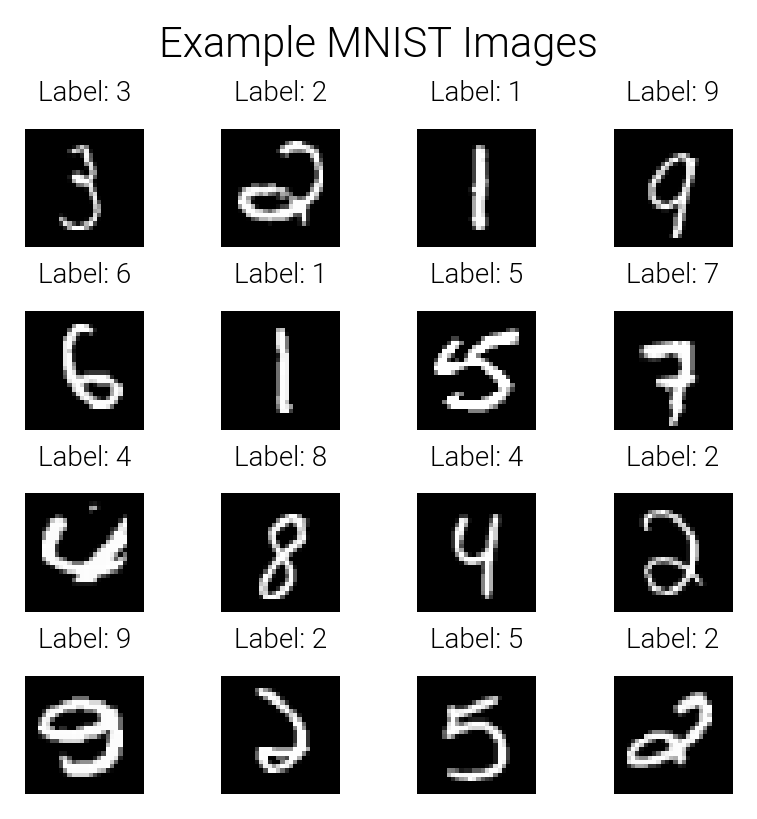

In [143]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets


PIXEL_RANGE= 255
IMAGE_SIZE = [28, 28]
NUM_PIXELS_IN_IMAGE = np.prod(IMAGE_SIZE)

NUM_CLASSES = 10 # Number of digits in MNIST

# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: {'images': (PIXEL_RANGE * x).long()})
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    inputs, labels = next(iter(dataloader))
    
    example_image = inputs['images'][0]
    images = inputs['images'][:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images', fontsize=30)
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Building a Digit Classifier using Cirkit &#x1F50C;

In this section, we show how to train our circuit such that it can classify MNIST digits.
We will show 3 ways of training:

1. Generative Training
2. Discriminative Training
3. Combination of Both (i.e. using a multi-task objective)

### Notation

* $\mathbf{x}$ are the pixels of an image
* $y$ is the MNIST digit class, i.e. $y \in \{0,\ldots,9\}$
* $N$ is the number of training examples

## 1. Generative Training Objective (LL)

### Modelling $P(\mathbf{x})$ directly
We have [already seen](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb) how we can fit a circuit to estimate the distribution of our MNIST images, i.e. $P(\mathbf{x})$. 
However, fitting the model this way is no good for a digit **classifier** because the model does not include a random variable for the digit class.
**What if we also want to model the class of each image?**

### Modelling $P(\mathbf{x})$ by also including the digit class, i.e. $P(\mathbf{x} \mid y)$.

In order to include the class image in our model, we can fit $P(\mathbf{x} \mid y)$ for $y \in \{ 0 \ldots 9 \}$.
We can then obtain $P(\mathbf{x})$ by marginalising out $y$:

$$
P(x) = \sum_{y} P(\mathbf{x} \mid y) P(y)
$$

**But how do we construct a circuit to give us the conditional distributions $P(\mathbf{x} \mid y)$?**
### Estimating $P(\mathbf{x} \mid y)$ for $y \in \{ 0\ldots 9 \}$
Recall that when we were modelling $P(\mathbf{x})$ directly, our circuit had a single log-probability output, which we interpreted as $\log P(\mathbf{x})$.
In our case, we could instead fit $10$ separate circuits, one per image class. However, this is wasteful.
Images have shared characteristics that all $10$ circuits would have to re-learn from scratch, separately.
Can we do better?


### Parameter Sharing
Yes! We can use **parameter sharing**, i.e., we can share the early layers of our circuit and only adapt the output layer to produce our conditional distributions.
Since there are $10$ classes, we change the last layer of our circuit to output $10$ log-probabilities: the probability mass over images for each class, $P(\mathbf{x} \mid y)$.
We can do so by specifying the `num_classes` option in `Circuit.from_region_graph`.

As in our earlier notebooks, we have a choice for the region graph and input parametrisations.
We use a similar setup as previous notebooks, but we change the `num_classes` argument to be 10 and use 3 repetitions of RandomBinaryTrees to [mimic the RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a-supp.pdf).

In [144]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates.utils import Parameterization, parameterization_to_factory
from cirkit.templates.region_graph import QuadGraph, QuadTree


NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64


def build_class_conditional_circuit(num_classes: int,
                                    rg: RegionGraph,
                                    sum_prod_layer: str = 'cp') -> Circuit:
    input_factory = lambda scope, y, z: CategoricalLayer(
        scope=scope,
        num_categories=PIXEL_RANGE+1,
        num_channels=1, # These are grayscale images
        num_output_units=NUM_INPUT_UNITS # Overparameteribzation
    )

    # Note that below intialisation is needed
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)
    
    circuit = Circuit.from_region_graph(
        rg,
        input_factory=input_factory,
        sum_weight_factory= sum_weight_factory,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer,
        num_classes=num_classes,     # <- This line makes our circuit have num_classes outputs
    )
    return circuit


rg = RandomBinaryTree(NUM_PIXELS_IN_IMAGE, depth=None, num_repetitions=3)
circuit = build_class_conditional_circuit(NUM_CLASSES, rg, 'cp')

## Estimating $P(\mathbf{x})$


Now that we have a circuit that can compute $P(\mathbf{x} \mid y)$, let's compute $P(\mathbf{x})$ via marginalisation:

$$
P(x) = \sum_{y} P(\mathbf{x} \mid y) P(y)
$$


### Working with $\log$ Probabilities

For numerical reasons our circuits output log probabilities. We can rewrite the above equation as:

$$
\log P(x) = \log \sum_{y} P(\mathbf{x} \mid y) P(y)
$$

Since our circuit outputs log probabilities, in order to compute the sum on the right we use a `logsumexp` operation, as can be seen on the highlighted line below:


### Generative Loss in Code
```python
def generative_loss(log_probs, labels, marginalize=True, prior=None):
    batch_size, num_classes = log_probs.shape

    if marginalize:
        # Set prior to uniform if not set
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        #             ====  LOGSUMEXP ====
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
    else:
        # Select the logprob given by y - i.e. the true label
        d_log_probs = log_probs[torch.arange(batch_size), labels]
    # Compute average over examples (1/N)
    # Negative since max log likelihood = min negative log likelihood
    return -torch.mean(d_log_probs)
```


## 2. Discriminative Training Objective  (CE)

Ok, so we have a model that can generate images while taking the image class into account. But if we want to build a classifier, we need to model $P(y \mid \mathbf{x})$.


### Using Bayes' rule to convert our Generator into a Classifier

We can use Bayes' rule to flip $P(\mathbf{x} \mid y)$ to our required $P(y \mid \mathbf{x})$.

$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)P(y)}{\sum_y P(\mathbf{x} \mid y)P(y)}$$

### Uniform Prior $P(y)$
While we could estimate $P(y)$ empirically, we assume a uniform prior here for simplicity. Doing so allows us to simplify the above expression to:

$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)}{\sum_y P(\mathbf{x} \mid y)}$$

### Working with $\log$ Probabilities

As a last step, for numerical reasons our circuit outputs log probabilities, so we rewrite the above in terms of log probabilities as:

$$\log P(y \mid \mathbf{x}) = \log P(\mathbf{x} \mid y) - \log \sum_y P(\mathbf{x} \mid y)$$

Since our circuit outputs log probabilities, in order to compute the sum on the right we use a `logsumexp` operation.

Great, so we can now estimate the probability of an image class given an image! What's more, we can train using this discriminative loss:

### Discriminative Loss in Code
```python
def discriminative_loss(log_probs, labels):
    batch_size, num_classes = log_probs.shape
    # Select log P(x | y) where y is the true label
    target_log_prob = log_probs[torch.arange(batch_size), labels]
    # Compute log P(y | x)
    d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
    return -torch.mean(d_log_probs)
```

## 3. Combining Both Objectives

<div style="max-width:25%; margin: auto;">

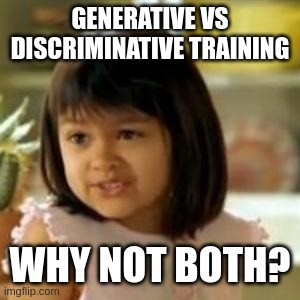

</div>

The RAT SPN papepr also considers training using a trade-off between the two objectives.
To do so, it introduces a parameter $\lambda \in [0, 1]$ and computes a combined loss as:

<div style="max-width:45%; margin: auto;">
    
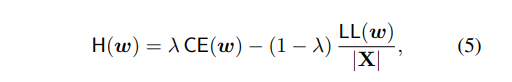

</div>

* $\lambda = 0  \rightarrow$ Model trained only generatively
* $\lambda = 1  \rightarrow$ Model trained only contrastively
* $\lambda \in (0, 1) \rightarrow$ trade-off between losses

### Losses on different scale
Note that the generative (NLL) and discriminative (CE) losses are on different scales, primarily because they are defined on a different number of random variables.
CE is defined over a single random variable, $y$, while NLL is defined over $28 \times 28=784$ pixels.
To make the interpolation more reasonable, we therefore divide the NLL loss by $|X|$, i.e. $784$ in our case.


### Both Objectives in Code
Below we put everything together in the `MNISTClassifier` class.

In [145]:
from collections import defaultdict

from cirkit.backend.torch.queries import IntegrateQuery
from cirkit.utils.scope import Scope
from cirkit.pipeline import compile


print_every = 100
# Set the torch device to use
device = torch.device('cuda')


class MNISTClassifier(object):

    """A class that implements class conditional classifiers for circuits.
    It includes helper functions for computing generative and discriminative
    loss and interpolating between the two."""

    def __init__(self, model, interpolation=.5, scale_gen=1., scale_dis=1.):
        self.model = model
        self.marginal_query = IntegrateQuery(self.model)
        assert 0 <= interpolation <= 1
        self.interpolation = interpolation
        self.scale_gen = scale_gen
        self.scale_dis = scale_dis

    def __call__(self, **kwargs):

        xx = kwargs['images']
        yy = kwargs['labels']
        mm = kwargs.get('masks', None)

        assert xx.shape[0] == yy.shape[0]
        
        if mm is None:
            log_probs = self.model(xx)
        else:
            assert xx.shape[0] == len(mm)
            log_probs = self.marginal_query(xx, integrate_vars=[Scope(list(mask.numpy())) for mask in mm])            

        batch_size, num_channels, num_classes = log_probs.shape
        assert num_channels == 1
        assert num_classes > 1

        # Remove channel dim (which is one)
        log_probs = log_probs.squeeze(dim=1)

        gen_loss = self.generative_loss(log_probs, yy, marginalize=True)
        dis_loss = self.discriminative_loss(log_probs, yy)

        # lambda * CE(w) - (1-lambda) LL(w)
        loss = self.interpolation * dis_loss * self.scale_dis + (1 - self.interpolation) * gen_loss * self.scale_gen

        probs = torch.exp(log_probs - torch.logsumexp(log_probs, dim=1, keepdims=True))

        image_log_probs = self.image_log_probs(log_probs)

        return dict(loss=loss,
                    probs=probs,
                    image_log_probs=image_log_probs,
                    gen_loss=gen_loss,
                    dis_loss=dis_loss)
    
    @staticmethod
    def image_log_probs(log_probs, prior=None):
        # Compute P(x) by marginalising out y, i.e. sum_i P(x|y)P(y)
        # Set prior to uniform if not set
        batch_size, num_classes = log_probs.shape
        
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
        return d_log_probs

    @staticmethod
    def cond_image_log_probs(log_probs, labels):
        # Compute conditional probability P(x|y) where y is the known class of the image
        batch_size, num_classes = log_probs.shape
        
        d_log_probs = log_probs[torch.arange(batch_size), labels]
        return d_log_probs
        
    @staticmethod
    def generative_loss(log_probs, labels, marginalize=True, prior=None):
        if marginalize:
            d_log_probs = MNISTClassifier.image_log_probs(log_probs, prior=prior)
        else:
            # Select the logprob given by y - i.e. the true label
            d_log_probs = MNISTClassifier.cond_image_log_probs(log_probs, labels)
        return -torch.mean(d_log_probs)

    @staticmethod
    def discriminative_loss(log_probs, labels):
        batch_size, num_classes = log_probs.shape
        # Select log P(x | y) where y is the true label
        target_log_prob = log_probs[torch.arange(batch_size), labels]
        # Compute log P(y | x)
        d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
        return -torch.mean(d_log_probs)


def train_model(circuit, dataloader, interpolation=.5):
    # Set some seeds
    np.random.seed(42)
    torch.manual_seed(42)
    
    
    cc = compile(circuit)
    # Move the circuit to chosen device
    cc = cc.to(device)
    cc.train()
    
    
    model = MNISTClassifier(cc,
                            interpolation=interpolation,
                            scale_gen=1./NUM_PIXELS_IN_IMAGE,
                            scale_dis=1.)
    
    num_epochs = 5
    step_idx = 0
    stats, step_stats = defaultdict(list), defaultdict(float)
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(cc.parameters(), lr=0.01)
    
    
    for epoch_idx in range(num_epochs):
        for i, ((inputs), labels) in enumerate(dataloader):
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            
            result = model(images=images, labels=labels, masks=masks)
            
            loss = result['loss']
            loss.backward()
    
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
    
            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())
            
            step_stats['loss'] += loss.detach().item() * BS
            step_stats['accuracy'] += acc.detach().item() * BS
            step_stats['gen_loss'] += result['gen_loss'].detach().item() * BS
            step_stats['dis_loss'] += result['dis_loss'].detach().item() * BS


            step_idx += 1
            if step_idx % print_every == 0:
                for k, v in step_stats.items():
                    step_stats[k] = step_stats[k] / (print_every * BS)
                print(f"Step {step_idx}: Average Loss: {step_stats['loss']:.3f}: Average Accuracy: {step_stats['accuracy'] * 100:.2f}%")

                for k, v in step_stats.items():
                    stats['train_%s' % k].append(v)

                step_stats = defaultdict(float)

    return model, stats

models, stats = dict(), dict()
# Train models with different interpolation
for lamda in [0., .25, .5, .75, 1.]:
    model_name = 'RandomBinaryTree $\\lambda=$%.2f' % lamda
    rg = RandomBinaryTree(NUM_PIXELS_IN_IMAGE, depth=None, num_repetitions=3)
    circuit = build_class_conditional_circuit(NUM_CLASSES, rg, 'cp')
    models[model_name], stats[model_name] = train_model(circuit, train_dataloader, interpolation=lamda)

Step 100: Average Loss: 4.388: Average Accuracy: 10.23%
Step 200: Average Loss: 2.097: Average Accuracy: 10.24%
Step 300: Average Loss: 1.304: Average Accuracy: 10.70%
Step 400: Average Loss: 1.215: Average Accuracy: 11.36%
Step 500: Average Loss: 1.186: Average Accuracy: 9.52%
Step 600: Average Loss: 1.186: Average Accuracy: 10.29%
Step 700: Average Loss: 1.176: Average Accuracy: 9.54%
Step 800: Average Loss: 1.166: Average Accuracy: 9.21%
Step 900: Average Loss: 1.172: Average Accuracy: 8.94%
Step 1000: Average Loss: 1.163: Average Accuracy: 8.37%
Step 1100: Average Loss: 1.170: Average Accuracy: 9.11%
Step 100: Average Loss: 4.108: Average Accuracy: 10.00%
Step 200: Average Loss: 2.356: Average Accuracy: 13.45%
Step 300: Average Loss: 1.273: Average Accuracy: 64.30%
Step 400: Average Loss: 1.039: Average Accuracy: 85.87%
Step 500: Average Loss: 0.973: Average Accuracy: 90.33%
Step 600: Average Loss: 0.948: Average Accuracy: 93.80%
Step 700: Average Loss: 0.933: Average Accuracy: 94.

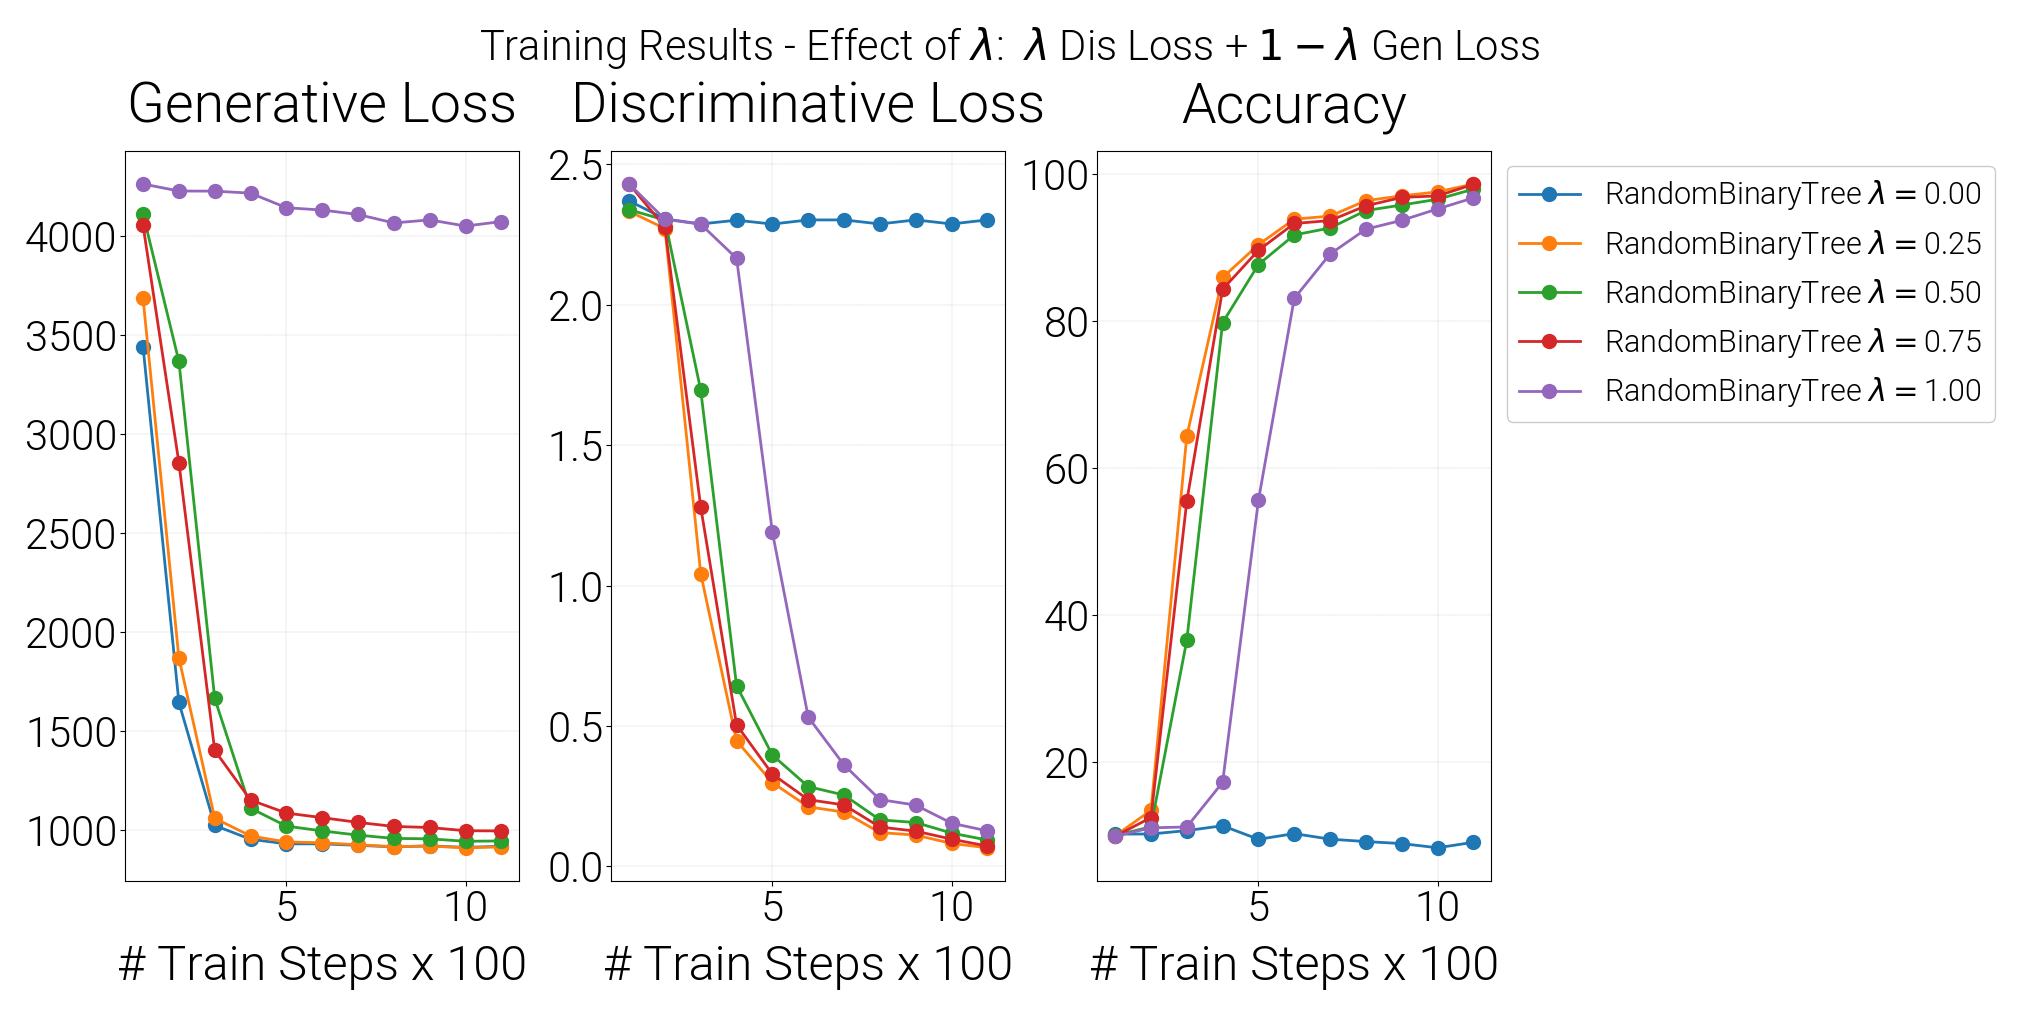

In [146]:
def plot_train_stats(stats):
    # Plot figures of results
    fig, axes = plt.subplots(figsize=(20, 10), ncols=3)
    for k, v in stats.items():
        xx = np.arange(1, len(v['train_gen_loss'])+1)
        lbl = k.replace('lambda ', '$\\lambda$=')
        axes[0].plot(xx, v['train_gen_loss'], '-o', label=lbl)
        axes[1].plot(xx, v['train_dis_loss'], '-o', label=lbl)
        axes[2].plot(xx,[a * 100 for a in v['train_accuracy']], '-o', label=lbl)
    
    axes[0].set_title('Generative Loss')
    axes[1].set_title('Discriminative Loss')
    axes[2].set_title('Accuracy')
    axes[0].set_xlabel('# Train Steps x %d' % print_every)
    axes[1].set_xlabel('# Train Steps x %d' % print_every)
    axes[2].set_xlabel('# Train Steps x %d' % print_every)
    
    plt.suptitle('Training Results - Effect of $\\lambda$:  $\\lambda$ Dis Loss + $1-\\lambda$ Gen Loss', fontsize=30)
    plt.legend(bbox_to_anchor=(1., 1.), fontsize=22)
    plt.tight_layout()
    plt.show()


plot_train_stats(stats)

In [147]:
import pandas as pd


def test_model(classifier, dataloader):
    stats = defaultdict(float)
    
    with torch.no_grad():
        test_lls = 0.0
        classifier.model.eval()

        N = 0
        for inputs, labels in dataloader:

            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            result = classifier(images=images, labels=labels, masks=masks)

            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())

            stats['test accuracy'] += acc.detach().item() * BS
            stats['test gen loss'] += result['gen_loss'].detach().item() * BS
            stats['test dis loss'] += result['dis_loss'].detach().item() * BS
    
            N += BS
    
        # Compute average test log-likelihood and bits per dimension
        for k, v in stats.items():
            stats[k] = stats[k] / N

        stats['test bpd'] = stats['test gen loss'] / (NUM_PIXELS_IN_IMAGE * np.log(2.0))
    return stats

test_stats = dict()
for k, model in models.items():
    test_stats[k] = test_model(model, test_dataloader)

df = pd.DataFrame.from_dict(test_stats, orient='index')
df

,test accuracy,test gen loss,test dis loss,test bpd
RandomBinaryTree $\lambda=$0.00,0.0934,913.628749,2.302545,1.681234
RandomBinaryTree $\lambda=$0.25,0.9396,909.462687,0.202100,1.673568
RandomBinaryTree $\lambda=$0.50,0.9262,937.033502,0.242372,1.724303
RandomBinaryTree $\lambda=$0.75,0.9260,984.209719,0.245057,1.811115
RandomBinaryTree $\lambda=$1.00,0.9273,4067.161532,0.240630,7.484278


# Tolerance to Dropped Pixels via Marginalisation


## Data with missing inputs
Sometimes we need to model data with missing inputs!


## Example

Let's visualise what it looks like to drop $p\%$ of the pixels from an image, dropped pixels shown in orange below for $p \in [10, 25, 50, 75]$.

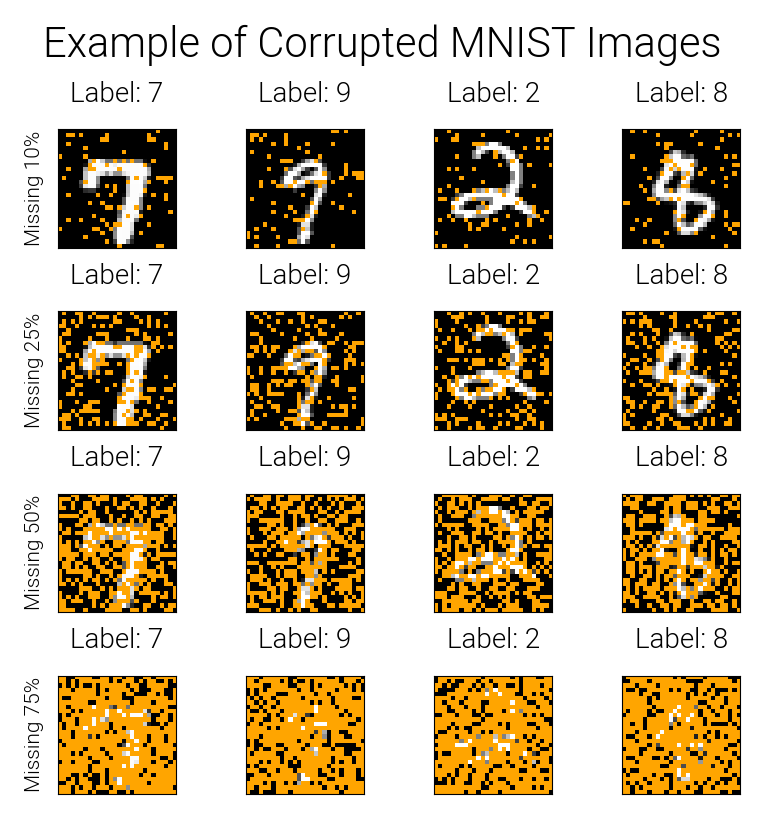

In [148]:
def sample_masks(image_size, num_images, p=.5):
    num_pixels = np.prod(image_size)
    num_samples = int(p*num_pixels)
    masks = [list(np.random.choice(range(np.prod(image_size)), size=num_samples, replace=False))
             for i in range(num_images)]
    return masks


def mask_to_image(image_size, mask):
    bool_mask = np.ones(np.prod(image_size), dtype=bool)
    bool_mask[mask] = False
    bool_mask = bool_mask.reshape(image_size)
    return bool_mask


gridsize = 4

inputs, labels = next(iter(train_dataloader))
images = inputs['images'][:4].repeat(gridsize, 1, 1, 1)
labels = labels[:4].repeat(gridsize)

fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

dropout = [.1, .25, .5, .75]

for i in range(gridsize):
    axes[i, 0].set_ylabel('Missing %d%%' % int(dropout[i]* 100), rotation=90, fontsize=15)
# Plot each image
for i, ax in enumerate(axes.flat):
    # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
    img = images[i].numpy().squeeze()
    img = img.reshape(*IMAGE_SIZE, 1)
    img = img.repeat(4, axis=2)
    mask = sample_masks(IMAGE_SIZE, 1, p=dropout[i//gridsize])
    mask = mask_to_image(IMAGE_SIZE, mask)
    img[:, :, -1] = mask * 255

    # Display the image
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Help distinguish between white pixels and missing pixels (in red)
    ax.set_facecolor("orange")
    ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
# Adjust spacing between subplots
fig.suptitle('Example of Corrupted MNIST Images', fontsize=30)
plt.tight_layout()
plt.show()

# Solution
We can handle this in cirkit by marginalising out the random variables which correspond to missing inputs.

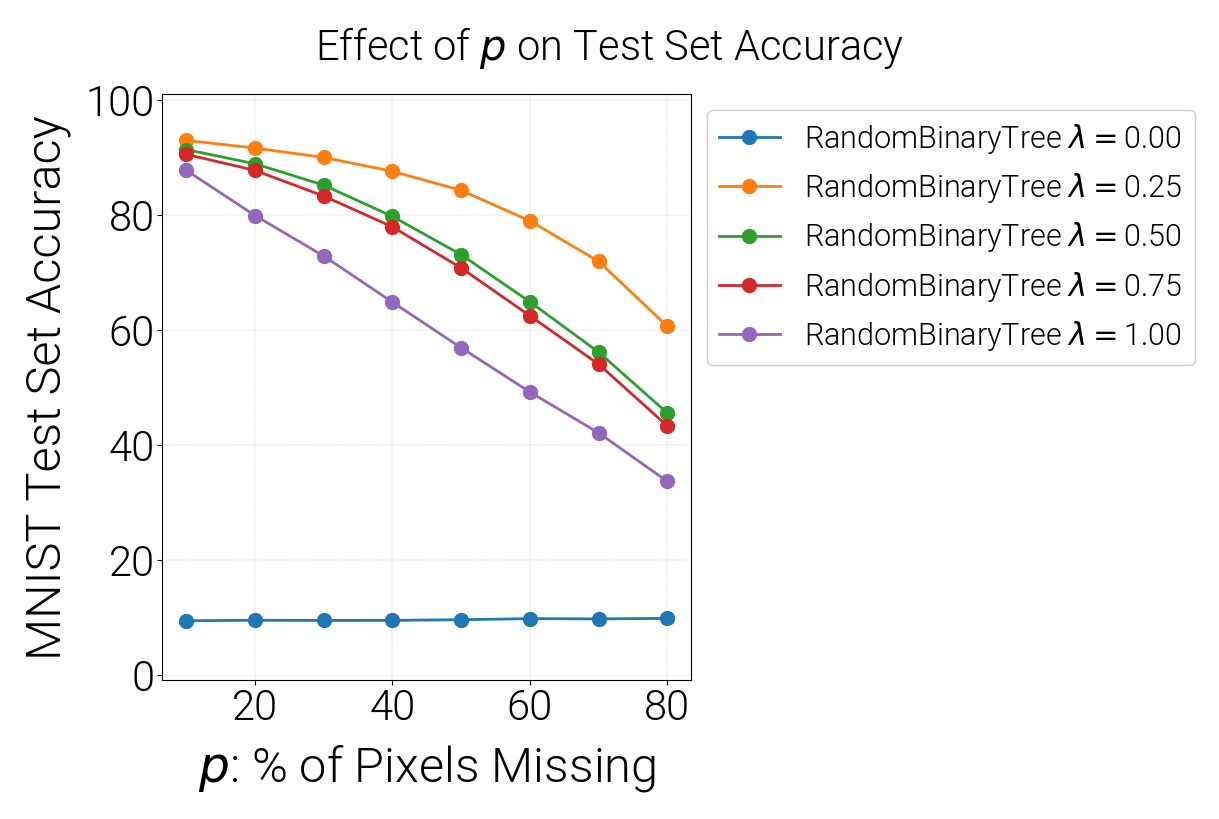

In [149]:
def mask_transform(p):
    return transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range and append randomly generated mask
    transforms.Lambda(lambda x: {'images':(PIXEL_RANGE * x).long(),
                                 'masks': np.array(sample_masks(IMAGE_SIZE, 1, p=p)).ravel()})
    ])

dropout = np.arange(0, 1., .1)

m_test_stats = []
for p in dropout:

    m_data_test = datasets.MNIST('datasets', train=False, download=True, transform=mask_transform(p))

    # Instantiate the training and testing data loaders
    mask_test_dataloader = DataLoader(m_data_test, shuffle=False, batch_size=2)

    # example, _ = next(iter(mask_test_dataloader))
    # for ex in example['masks']:
    #     print(ex)
    for k, model in models.items():
        stats = test_model(model, mask_test_dataloader)
        stats['p'] = p
        stats['model'] = k
        m_test_stats.append(stats)


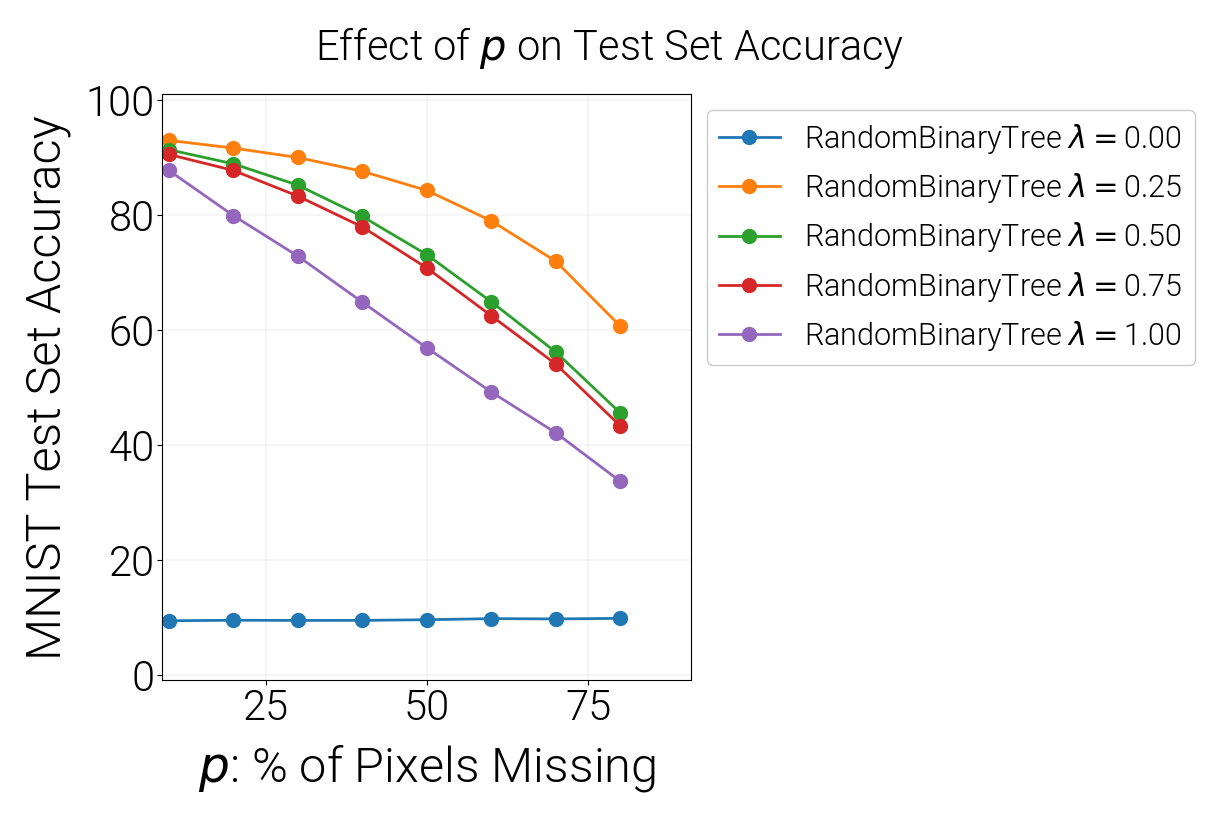

In [157]:
fig, ax = plt.subplots(figsize=(12, 8))

for name, e in pd.DataFrame.from_records(m_test_stats).groupby(['model']):
    ax.plot(e['p'] * 100, e['test accuracy'] * 100, '-o', label=name)
plt.xlabel('$p$: % of Pixels Missing')
plt.ylabel('MNIST Test Set Accuracy')

plt.suptitle('Effect of $p$ on Test Set Accuracy', fontsize=30)
plt.legend(bbox_to_anchor=(1., 1.), fontsize=22)
plt.ylim([-1, 101])
plt.xlim([9, 91])
plt.tight_layout()
plt.show()

# Group by below is for visualisation purposes (index).
# Each group contains a single row, so just take that using first().
# df = pd.DataFrame.from_records(m_test_stats).groupby(['model', 'p']).first()
# df

# Out of Distribution Detection


## Load Fashion MNIST as unseen dataset

Each training and test example is assigned to one of the following labels:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

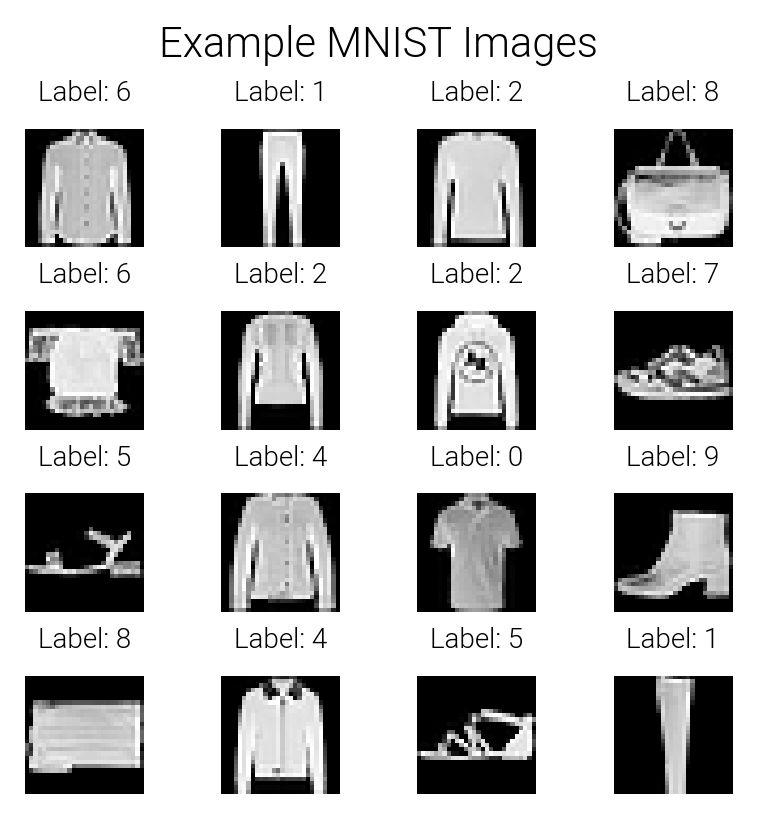

In [150]:
f_data_train = datasets.FashionMNIST('datasets', train=True, download=True, transform=transform)

# Instantiate the training and testing data loaders
f_train_dataloader = DataLoader(f_data_train, shuffle=True, batch_size=256)

plot_sample_images(f_train_dataloader, gridsize=4)

Below we compute the log likelihood of images from:
1. MNIST (training set)
2. MNIST (test set)
3. Fashion MNIST: an example Out Of Distribution (OOD) dataset

In [151]:
loaders = [train_dataloader, test_dataloader, f_train_dataloader]
loader_names = ['train (MNIST)', 'test (MNIST)', 'OOD: Fashion MNIST']

scores = defaultdict(lambda: defaultdict(list))
for k, model in models.items():
    with torch.no_grad():
        for loader in loaders:
            ls = str(loader)
            for inputs, labels in loader:
                BS = labels.shape[0]
                images = inputs['images'].view(BS, 1, -1).to(device)
                labels = labels.view(BS).to(device)
                log_probs = model(images=images, labels=labels)['image_log_probs']
                log_probs = log_probs.detach().cpu().numpy()
                scores[k][ls].append(log_probs)

for m, vals in scores.items():
    for k in vals.keys():
        scores[m][k] = np.hstack(scores[m][k])

# Results

If our circuit is succesfully modelling MNIST digits, it should assign them a large log likelihood.
At the same time, images from other datasets, e.g. Fashion MNIST, should be assigned a lower log likelihood.

Below we plot histograms of the log likelihood assigned by each model to the above examples.
As can be seen from the histogram, the circuit indeed assigns much lower log likelihood to examples from fashion MNIST.

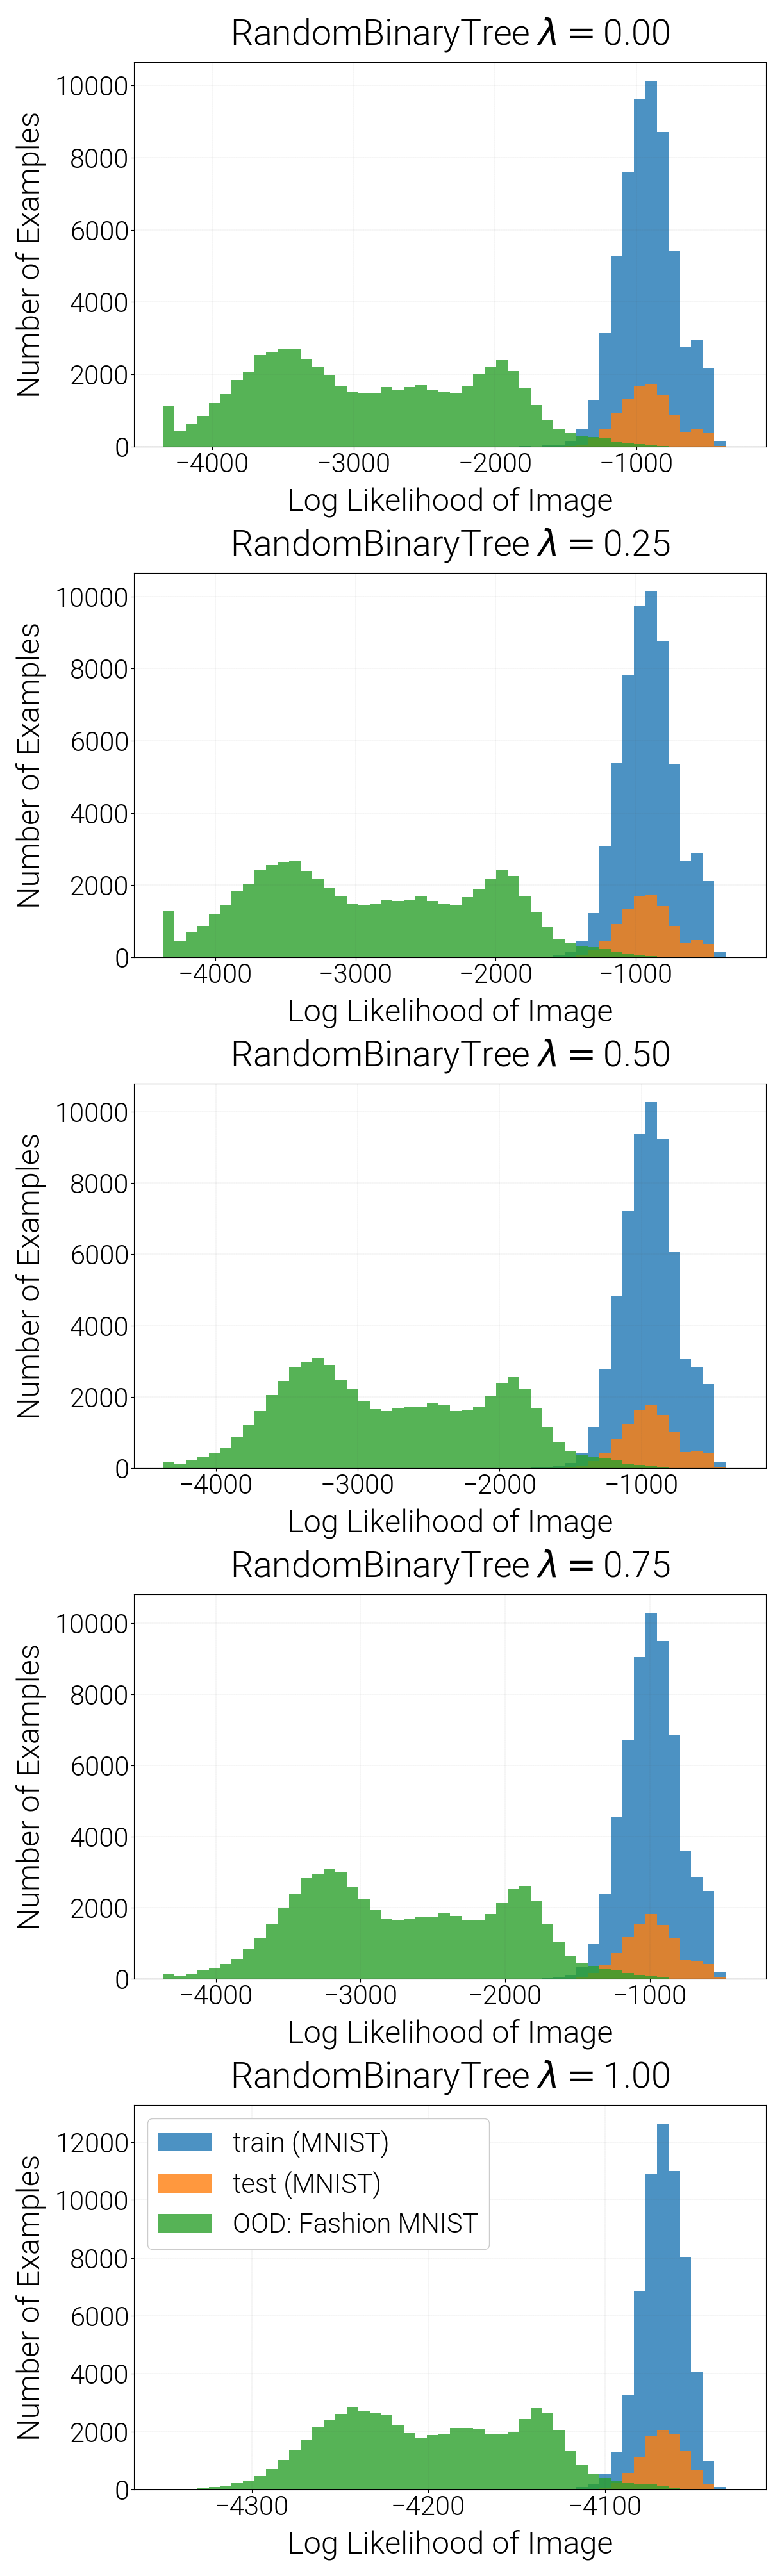

In [152]:
for m, vals in scores.items():
    for k in vals.keys():
        scores[m][k] = np.hstack(scores[m][k])


fig, axes = plt.subplots(nrows=len(models), squeeze=0, figsize=(12, 8*len(models)))
axes = axes.reshape(-1)
                         
for i, (m, vals) in enumerate(scores.items()):
    bins = np.histogram(np.hstack([v for v in vals.values()]), bins=50)[1]
    for j, k in enumerate(vals.keys()):
        axes[i].hist(scores[m][k], bins, density=False, label=loader_names[j], alpha=.8)
    axes[i].set_xlabel('Log Likelihood of Image')
    axes[i].set_ylabel('Number of Examples')
    axes[i].set_title(m)
plt.tight_layout()
plt.legend()
plt.show()

# Conclusion


Circuits are cool and cirkit makes using them a lot easier! We have seen:

1. How to build a multi-class classifier from a circuit and train it generatively, discriminatively and with a combined multi-task objective.
2. How to marginalise out missing inputs and how circuits are still relatively robust in performance when doing so.
3. How to do Out Of Distribution (OOD) estimation with circuits and showed how this works for MNIST vs Fashin MNIST (OOD).


However, we have only scratched the surface!

# What Next?

Some ideas for thing you may want to explore further:

* In earlier notebooks we learned about region graphs that are better for images. Adapt the notebook to use these.
* We have also learned about SoS and PICs, can we get better results with these?
* In the RAT-SPN paper, ``dropout'' is also used during training. Apply input dropout by marginalising out random subsets of features during training.